In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.distributions import Normal as norm
from termcolor import colored
from sklearn.decomposition import PCA
from scipy import linalg as LA
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import multinomial
from scipy.stats import logistic
from Main_functions import *
import random
from numpy import genfromtxt

### Setting the data distribuation 

Pairs $(x_i,y_i)\in \mathbb{R}^d\times \mathbb{R}^d$ for $i=1, \ldots, N$ are generated i.i.d. from density distribuation $f(\cdot)\times f(\cdot)$.  

Parameters:

$d:$ dimention of data points

$N:$ number of pairs

$f(\cdot):$ density distribuation


### Given the eigenvalues of ground truth $M_t$, we randomly generate it.

In [2]:
csv_path = 'CSVs/logistic_logistic_'
image_path = 'Images/logistic_logistic_'
title_suffix = '\n (Logistic Noise Logistic model)'
noise_type = 'Logistic'
model_type = 'Logistic'

In [3]:
d = 10
rank = 5
seed = 2023

In [4]:
np.random.seed(seed)
non_zero_eigens_of_M_star = np.round(np.random.uniform(low=0.0, high=1.0, size= rank), 2)
non_zero_eigens_of_M_star

array([0.32, 0.89, 0.59, 0.13, 0.14])

In [5]:
# eigenvalues of $M_t$
diag = np.zeros(d)
diag[:rank] = non_zero_eigens_of_M_star
diag

array([0.32, 0.89, 0.59, 0.13, 0.14, 0.  , 0.  , 0.  , 0.  , 0.  ])

In [6]:
data_model = DG(diag, seed = 22)

Ground truth M_t and B_t are generated (M_t = B_t @ B_t.T)
To access to M_t and B_t, use .M_t and .B_t


In [7]:
data_model.M_diag

array([0.32, 0.89, 0.59, 0.13, 0.14, 0.  , 0.  , 0.  , 0.  , 0.  ])

In [8]:
data_model.M_t.shape, data_model.B_t.shape

((10, 10), (10, 10))

### Given the eigenvalue of covariance matrix Cov, we randomly generate it.

In [9]:
np.random.seed(2024)
diag_cov = np.round(np.random.uniform(low=0.0, high=1.0, size= d), 2)
diag_cov

array([0.59, 0.7 , 0.19, 0.04, 0.21, 0.11, 0.73, 0.68, 0.47, 0.45])

In [10]:
diag_cov.sum()

4.17

In [11]:
Sigma, U_sigma = random_covariance(diag_cov, seed = 21)

In [12]:
f = multivariate_normal(mean = np.zeros(d), cov = Sigma)

### What is the average of squared norm of points generating where $x\sim f(x)$ with $\mathbb{E}(x) = \mu$ and ${\rm Cov}(x) = \Sigma$

If $x\sim f(x)$ where $\mathbb{E}(x) = \mu$ and ${\rm Cov}(x) = \Sigma$, then 
\begin{align}
\mathbb{E}\left(x^\top Mx\right) & = \mathbb{E}\left({\rm tr}(x^\top Mx)\right)\\
 & = \mathbb{E}\left({\rm tr}(xx^\top M)\right)\\
 & = {\rm tr}\left(\mathbb{E}\left(xx^\top\right)M\right)\\
 & = {\rm tr}\left(\left[{\rm Cov}(x) - \mathbb{E}(x)\mathbb{E}(x)^\top\right]M\right)
\end{align}

If we set  $\mu = \mathbf{0}$, then 
$$\mathbb{E}\left(x^\top Mx\right) = {\rm tr}\left(\Sigma M\right).$$
Therefore, since $x$ and $y$ are independent, 
$$\mathbb{E}\left(\|x-y\|_M^2\right) = 2{\rm tr}\left(\Sigma M\right).$$

In [13]:
snm = 2 * np.trace(data_model.M_t @ Sigma)
print("squared norm mean = {}".format(snm))

squared norm mean = 1.6983720913430767


### Check the average empirically

In [14]:
N = 5000
X_1, Y_1 = sample(f, N)
sn = (((X_1 - Y_1) @ data_model.B_t)**2).sum()/N
print("emperical squared norm mean = {}".format(sn))

emperical squared norm mean = 1.7197533768399575


### Set $\tau$ to generate data points

In [15]:
tau = [1.3]
N = 20000
s = 5

In [16]:
var = logistic(loc = 0, scale = s).var()
var

82.24670334241132

In [17]:
X, Y, D_noisy, D_no_noisy = data_model.generate(f, N, tau = np.array(tau), 
                                          noise_type = noise_type, noise_par = s)

In [18]:
noise_amount = (D_noisy != D_no_noisy).mean()
print('the amount of noise: {}'.format(noise_amount))

the amount of noise: 0.4561


In [19]:
for i in range(len(tau)+1):
    print('number of pairs with {} as their labels is {}'.format(i,(D_no_noisy==i).sum()))

number of pairs with 0 as their labels is 10201
number of pairs with 1 as their labels is 9799


In [20]:
(D_no_noisy== 0).sum()/N

0.51005

### Change to PyTorch tensor!

In [21]:
X = torch.tensor(X, dtype = torch.float64)
Y = torch.tensor(Y, dtype = torch.float64)
D_noisy = torch.tensor(D_noisy, dtype = torch.torch.int64)
D_no_noisy = torch.tensor(D_no_noisy, dtype = torch.torch.int64)

In [22]:
X, Y, D, X_T, Y_T, D_T, D_no_noise_T, X_test, Y_test, D_test, D_no_noise_test = train_test_split(X, 
                                                                                                 Y, 
                                                                                                 D_noisy, 
                                                                                                 D_no_noisy, 
                                                                                                 n_train = 15000)

In [23]:
X.dtype, D.dtype

(torch.float64, torch.int64)

## Sample complexity

In [24]:
k = 10
n_labels = len(tau)+1

In [25]:
H = []
J = []
N = 50
while N < 200000:
    if N < 100:
        N += 10
    elif N < 1000:
        N += 100
    elif N < 5000:
        N+= 1000
    elif N<10000: 
        N += 5000
    elif N< 50000:
        N+= 10000
    elif N<100000: 
        N += 50000
    else:
        N+= 100000
        
        
    X, Y, D, X_T, Y_T, D_T, D_no_noise_T, X_test, Y_test, D_test, D_no_noise_test = gen_data(f, 
                                                                                         N + 5000, 
                                                                                         n_train = N, 
                                                                                         tau = np.array(tau), 
                                                                                         noise_type = noise_type,
                                                                                         noise_par = s,
                                                                                         data_model = data_model)
    
    
#     X, Y, D_noisy, D_no_noisy = data_model.generate(f, 
#                                                     N + 5000, 
#                                                     tau = np.array(tau), 
#                                                     noise_type = noise_type, 
#                                                     noise_par = s)
#     X = torch.tensor(X, dtype = torch.float64)
#     Y = torch.tensor(Y, dtype = torch.float64)
#     D_noisy = torch.tensor(D_noisy, dtype = torch.torch.int64)
#     D_no_noisy = torch.tensor(D_no_noisy, dtype = torch.torch.int64)
        
    print('round for N = {} has started'.format(N))
    
    J.append(N)
#     X, Y, D, X_T, Y_T, D_T, D_no_noise_T, X_test, Y_test, D_test, D_no_noise_test = train_test_split(X, 
#                                                                                                      Y, 
#                                                                                                  D_noisy, 
#                                                                                                  D_no_noisy, 
#                                                                                                  n_train = N)

    
    model = ML(d, k, n_labels, 
               X_T, Y_T, D_T, D_no_noise_T, 
               X_test, Y_test, D_test, 
               D_no_noise_test, Type = model_type) 
    
    model.train(learning_rate = 1e-1, 
                n_iters = 30000, 
                decay = .95, 
                show_log = False,
                f = f, 
                B_star = data_model.B_t, 
                tau_star = data_model.tau_t, 
                N = 1000)
    
    H.append(model)

round for N = 60 has started
round for N = 70 has started
round for N = 80 has started
round for N = 90 has started
round for N = 100 has started
round for N = 200 has started
round for N = 300 has started
round for N = 400 has started
round for N = 500 has started
round for N = 600 has started
round for N = 700 has started
round for N = 800 has started
round for N = 900 has started
round for N = 1000 has started
round for N = 2000 has started
round for N = 3000 has started
round for N = 4000 has started
round for N = 5000 has started
round for N = 10000 has started
round for N = 20000 has started
round for N = 30000 has started
round for N = 40000 has started
round for N = 50000 has started
round for N = 100000 has started
round for N = 200000 has started


In [26]:
X_new, Y_new, _, D_new = data_model.generate(f, 
                                             N = 10000, 
                                             tau = np.array(tau), 
                                             noise_type = None, 
                                             noise_par = None)

In [27]:
X_new = torch.tensor(X_new, dtype = torch.float64)
Y_new = torch.tensor(Y_new, dtype = torch.float64)
D_new = torch.tensor(D_new, dtype = torch.torch.int64)

In [28]:
H[-2].accuracy(X_new, Y_new, D_new)

0.9448

In [29]:
test_accuracy_no_noise  = [H[i].accuracy(X_new, Y_new, D_new) for i in range(len(H))]

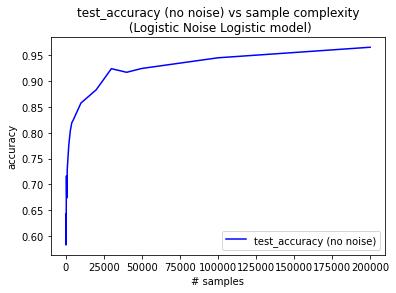

In [30]:
plt.plot(J, test_accuracy_no_noise, label = 'test_accuracy (no noise)', color = 'blue')
plt.legend()
plt.xlabel('# samples', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('test_accuracy (no noise) vs sample complexity' + title_suffix, fontsize=12)
plt.savefig(image_path + "test_accuracy_(no_noise)_vs_sample_complexity")
plt.show()

In [31]:
np.savetxt(csv_path + "sample_complexity_test_accuracy_no_noise.csv", 
           test_accuracy_no_noise,
           delimiter =", ", 
           fmt ='% s')

In [32]:
np.savetxt(csv_path + "sample_complexity_number_samples_list.csv", 
           J,
           delimiter =", ", 
           fmt ='% s')

In [33]:
test_accuracy_noisy  = [H[i].accuracy(H[i].X_test, H[i].Y_test, H[i].D_test) for i in range(len(H))]

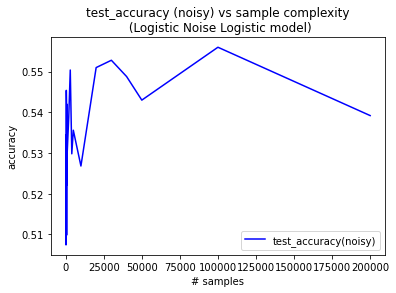

In [34]:
plt.plot(J, test_accuracy_noisy, label = 'test_accuracy(noisy)', color = 'blue')
plt.legend()
plt.xlabel('# samples', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('test_accuracy (noisy) vs sample complexity' + title_suffix, fontsize=12)
plt.savefig(image_path + "test_accuracy_(noisy)_vs_sample_complexity")
plt.show()

In [35]:
np.savetxt(csv_path + "sample_complexity_test_accuracy_noisy.csv", 
           test_accuracy_noisy,
           delimiter =", ", 
           fmt ='% s')

In [36]:
train_accuracy_noisy  = [H[i].accuracy(H[i].X_T, H[i].Y_T, H[i].D_T) for i in range(len(H))]

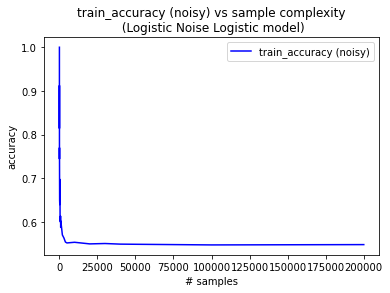

In [37]:
plt.plot(J, train_accuracy_noisy, label = 'train_accuracy (noisy)', color = 'blue')
plt.legend()
plt.xlabel('# samples', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('train_accuracy (noisy) vs sample complexity' + title_suffix, fontsize=12)
plt.savefig(image_path + "train_accuracy_(noisy)_vs_sample_complexity")
plt.show()

In [38]:
np.savetxt(csv_path + "sample_complexity_train_accuracy_noisy.csv", 
           train_accuracy_noisy,
           delimiter =", ", 
           fmt ='% s')

In [39]:
train_accuracy_no_noisy  = [H[i].accuracy(H[i].X_T, H[i].Y_T, H[i].D_no_noise_T) for i in range(len(H))]

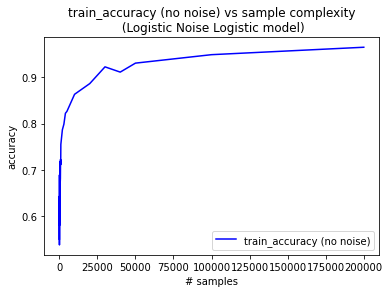

In [40]:
plt.plot(J, train_accuracy_no_noisy, label = 'train_accuracy (no noise)', color = 'blue')
plt.legend()
plt.xlabel('# samples', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('train_accuracy (no noise) vs sample complexity'+ title_suffix, fontsize=12)
plt.savefig(image_path + "train_accuracy_(no_noise)_vs_sample_complexity")
plt.show()

### 

In [41]:
np.savetxt(csv_path + "sample_complexity_train_accuracy_no_noisy.csv", 
           train_accuracy_no_noisy,
           delimiter =", ", 
           fmt ='% s')

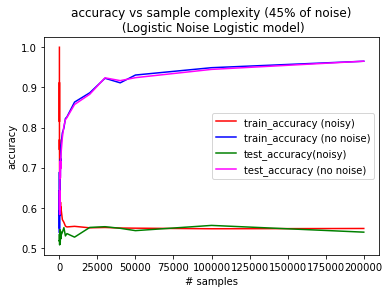

In [59]:
plt.plot(J[:], train_accuracy_noisy[:], label = 'train_accuracy (noisy)', color = 'red')
plt.plot(J[:], train_accuracy_no_noisy[:], label = 'train_accuracy (no noise)', color = 'blue')
plt.plot(J[:], test_accuracy_noisy[:], label = 'test_accuracy(noisy)', color = 'green')
plt.plot(J[:], test_accuracy_no_noise[:], label = 'test_accuracy (no noise)', color = 'magenta')

plt.legend()
plt.xlabel('# samples', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('accuracy vs sample complexity (45% of noise)' + title_suffix, fontsize=12)
plt.savefig(image_path + "all_accuracy_vs_sample_complexity", bbox_inches='tight')
plt.show()

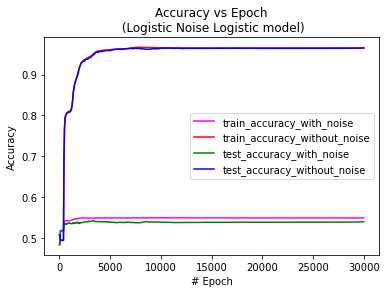

In [58]:
I = H[-1].epoch_history[:]
plt.plot(I, H[-1].train_accuracy_with_noise[:], label = 'train_accuracy_with_noise', color = 'magenta')
plt.plot(I, H[-1].train_accuracy_without_noise[:], label = 'train_accuracy_without_noise', color = 'red')
plt.plot(I, H[-1].test_accuracy_with_noise[:], label = 'test_accuracy_with_noise', color = 'green')
plt.plot(I, H[-1].test_accuracy_without_noise[:], label = 'test_accuracy_without_noise', color = 'blue')
plt.legend()
plt.xlabel('# Epoch', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.title('Accuracy vs Epoch' + title_suffix, fontsize = 12)
plt.savefig(image_path + 'all_accuracy_vs_epoch', bbox_inches='tight')
plt.show()

In [44]:
L_1_f_norm_history = [m.L_1_f_norm_history[-1] for m in H]

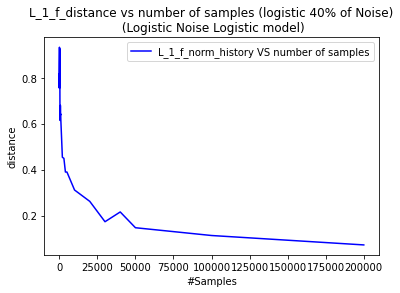

In [45]:
plt.plot(J, L_1_f_norm_history, label = 'L_1_f_norm_history VS number of samples', color = 'blue')
plt.legend()
plt.xlabel('#Samples', fontsize=10)
plt.ylabel('distance', fontsize=10)
plt.title('L_1_f_distance vs number of samples (logistic 40% of Noise)' + title_suffix, fontsize=12)
plt.savefig(image_path + "L_1_f_norm_history_vs_samples")
plt.show()

In [46]:
model = H[-1]

In [47]:
M_hat = (model.B @ model.B.T).detach().numpy()*s
M_star = data_model.M_t
tau_hat = model.Tau.detach().numpy()[0]*s
tau_star = data_model.tau_t[0]

print((np.abs(M_hat - M_star)).max())
print(np.abs(tau_hat-tau_star))

0.05669829841729224
0.07603266033321066


In [48]:
M_hat_normal = model.B @ model.B.T / model.Tau[0]

In [49]:
M_t_normal = data_model.M_t/tau[0]

In [50]:
(np.abs(M_t_normal - M_hat_normal.detach().numpy())).max()

0.05130705091648641

In [51]:
(np.abs(M_t_normal - M_hat_normal.detach().numpy())).mean()

0.011596114797656694

In [52]:
np.sqrt(np.sum((M_t_normal - M_hat_normal.detach().numpy())**2))/np.sqrt((M_t_normal**2).sum())

0.17877123252785948

In [53]:
print(model.Tau.detach().numpy())
print(np.array(tau))
print(np.array(tau)[0]/model.Tau.detach().numpy()[0], s)

[0.27520653]
[1.3]
4.72372508834638 5


In [54]:
L_1_f_norm(f, model.B.detach().numpy(), model.Tau.detach().numpy(), 
           data_model.B_t, data_model.tau_t, N = 10000)

0.07305527551497007

In [55]:
print(loss(X_T - Y_T, D_T, data_model.B_t/np.sqrt(s), data_model.tau_t/s, Type = model_type).item())
print(loss(X_T - Y_T, D_T, model.B, model.Tau, Type = model_type).item())
print(model.loss_history[-1].item())

0.682455296177959
0.6823640544049223
0.6823640544049223
